# Pytorch Paper Replicating

In this notebook, we're going to be replicating a machine learning research paper and creating a Vision Transformer(ViT) from scratch using PyTorch.

We'll then see how ViT, a state-of-the-art computer vision architecture, performs on our FoodVision Mini problem.

The goal of *paper replicating* is to replicate the advances with code so you can use the techniques for your own problem.

* Machine learning paper replicating involves turning a machine learning paper comprised of images/diagrams, maths and text into usable code and in our case, usable PyTorch code.

#### What is a machine learning research paper?

* Abstract : An overview/summary of the paper's main findings/contributions.
* Introduction : What's the paper's main problem and details of previous methods used to try and solve it.
* Method : How did the researchers go about conducting their research? For example, what model(s), data sources, training setups were used?
* Results : What are the outcomes of the paper? If a new type of model or training setup was used, how did it perform compared to previous methods? 
* Conclusion : What are the key takeaways from the paper? What are the future steps for research in the area?
* References : Other papers or resources mentioned in the paper.
* Appendix : Extra information such as mathematical proofs or theoretical concepts.

#### We are going to replicate the `Vanilla Vision Transformer`

# 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cpu
torchvision version: 0.20.1+cpu


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
# Regular imports
import matplotlib.pyplot as plt
import torch
import torchvision 

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print(f"{bcolors.WARNING} [INFO] torchinfo not found, installing torchinfo...{bcolors.ENDC}")
    %pip install -q torchinfo
    from torchinfo import summary
    
# Try to import the going_modular directory, download it from Github if it doesn't work

try:
    from going_modular import data_setup, engine
    from utils import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular directory scripts
    print(f"{bcolors.WARNING} [INFO] going_modular package not found, downloading...{bcolors.ENDC}")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning.git
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{bcolors.OKCYAN} [INFO] Using {device} device{bcolors.ENDC}")

 [INFO] Using cpu device


# 1. Get Data

In [5]:
# Download pizza, steak and sushi images from github
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [6]:
# Since i have already downloaded the data, i will just set the path
from pathlib import Path
image_path = Path("data/pizza_steak_sushi/")

# Setup directory paths to train and test data
train_dir = image_path / "train"
test_dir = image_path / "test"

image_path, train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi'),
 WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

# 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images

In [7]:
# From ViT paper, the authors used an image size of 224x224 and batch size of 4096

# Create a Image size (from Table 3 in the ViT Paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"{bcolors.OKCYAN} [INFO] Using manual transforms: {manual_transforms}{bcolors.ENDC}")

 [INFO] Using manual transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 2.2 Turn images into `DataLoader`'s

In [8]:
# Even though the authors used a batch size of 4096, we will use a batch size of 34 dues to memory constraints
# Set the batch size
BATCH_SIZE = 32

# Create the data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
    test_transform=manual_transforms,
    train_transform=manual_transforms
)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x252f118d6d0>,
 ['pizza', 'steak', 'sushi'])

## Visualize a single image

In [19]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

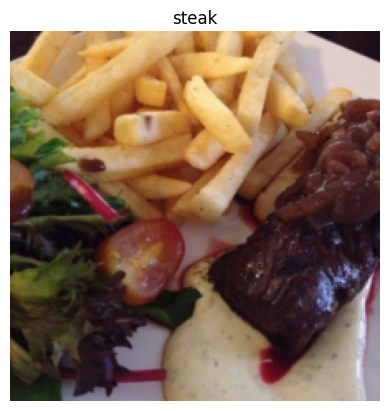

In [20]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib
plt.title(class_names[label])
plt.axis(False);

# 3. Replicating the ViT paper: an overview

## 3.1 Inputs and outputs, layers and blocks

ViT is a deep learning neural network architecture.

And any neural network architecture is generally comprised of layers.

And a collection of layers is often referred to as a block.

And stacking many blocks together is what gives us the whole architecture.

A layer takes an input (say an image tensor), performs some kind of function on it (for example what's in the layer's forward() method) and then returns an output.

So if a single layer takes an input and gives an output, then a collection of layers or a block also takes an input and gives an output.

Let's make this concrete:

* Layer - takes an input, performs a function on it, returns an output.
* Block - a collection of layers, takes an input, performs a series of functions on it, returns an output.
* Architecture (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

## 3.2 Getting specific: What ViT made of?

Remember, a research paper is often months of work compressed into a few pages so it's understandable for it to take of practice to replicate.

However, the main three resources we'll be looking at for the architecture design are:

1. Figure 1 - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.
2. Four equations in section 3.1 - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. Table 1 - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.


### 3.2.1 Exploring Figure 1.


1. Layers - takes an input, performs an operation or function on the input, produces an output.
2. Blocks - a collection of layers, which in turn also takes an input and produces an output.

![image](di83dth1.bmp)

*Figure 1 from the ViT Paper showcasing the different inputs, outputs, layers and blocks that create the architecture. Our goal will be to replicate each of these using PyTorch code.*

The ViT architecture is comprised of several stages:

1. Patch + Position Embedding (inputs) - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
2 Linear projection of flattened patches (Embedded Patches) - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
3. Norm - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().
4. Multi-Head Attention - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().
5. MLP (or Multilayer perceptron) - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).
6. Transformer Encoder - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
7. MLP Head - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.


### 3.2.2 Exploring the Four Equations

The next main part(s) of the ViT paper
![image](t5l9ztdb.bmp)

# 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

Let's start by creating the class, position and patch embeddinggs for the ViT architecture.

*<b>embedding</b>* is a learnable representation of some form and is often a vector.

## 4.1 Calculating patch emedding input and output shapes by hand

In [21]:
# Create sample values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
N = int((height * width) / patch_size**2)
print(f"{bcolors.OKCYAN} [INFO] Number of patches: {N}{bcolors.ENDC}")

 [INFO] Number of patches: 196


In [22]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape of the embedding layer
embedding_layer_output_shape = (N, patch_size**2 * color_channels)

print(f"{bcolors.OKGREEN} [INFO] Input Shape (single 2D image): {embedding_layer_input_shape}")
print(f"{bcolors.OKCYAN} [INFO] Embedding layer will turn {embedding_layer_input_shape} image shape into {embedding_layer_output_shape} shape{bcolors.ENDC}")

 [INFO] Input Shape (single 2D image): (224, 224, 3)
 [INFO] Embedding layer will turn (224, 224, 3) image shape into (196, 768) shape


## 4.2 Turning a single image into patches

Let's create the patch embedding layer

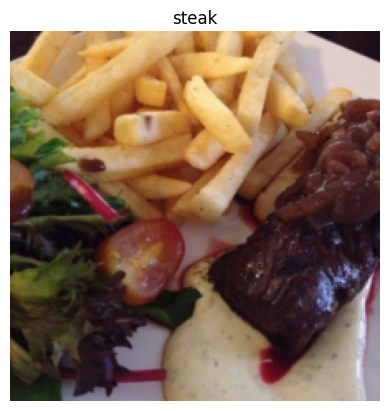

In [23]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust image for matplotlib
plt.title(class_names[label])
plt.axis(False);

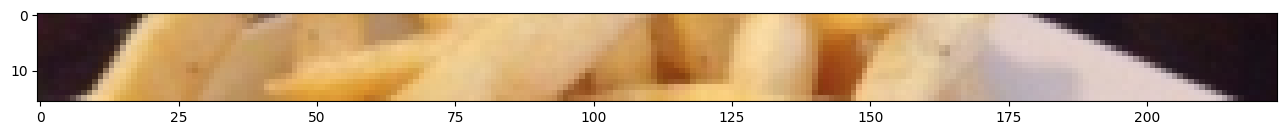

In [24]:
# Change image shape to be compatible with matplot lib (3, 224, 224) -> (224, 224, 3)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

 Number of patches per row: 14.0
 16 pixels x 16 pixels each.
0
16
32
48
64
80
96
112
128
144
160
176
192
208


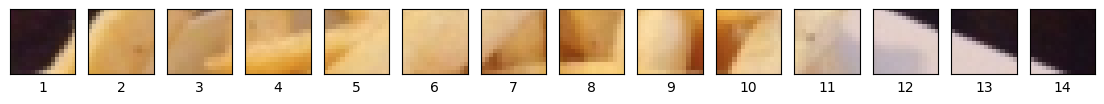

In [32]:
# Setup hyperparameters
image_size = 224
patch_size = 16
num_patches = image_size/patch_size
assert image_size % patch_size == 0, "image size must be divisible by patch size"
print(f"{bcolors.OKCYAN} Number of patches per row: {num_patches}\n {patch_size} pixels x {patch_size} pixels each.{bcolors.ENDC}")


# Create a series of subplots
fig, ax = plt.subplots(
    nrows=1,
    ncols=int(num_patches),
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, image_size, patch_size)):
    # Select the patch
    print(patch)
    ax[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    ax[i].set_xlabel(i+1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    

[INFO] Number of patches per row: 14      
patch_size 16 pixels x 16 pixels each.      
Number of patches per column: 14        
Total number of patches: 196      


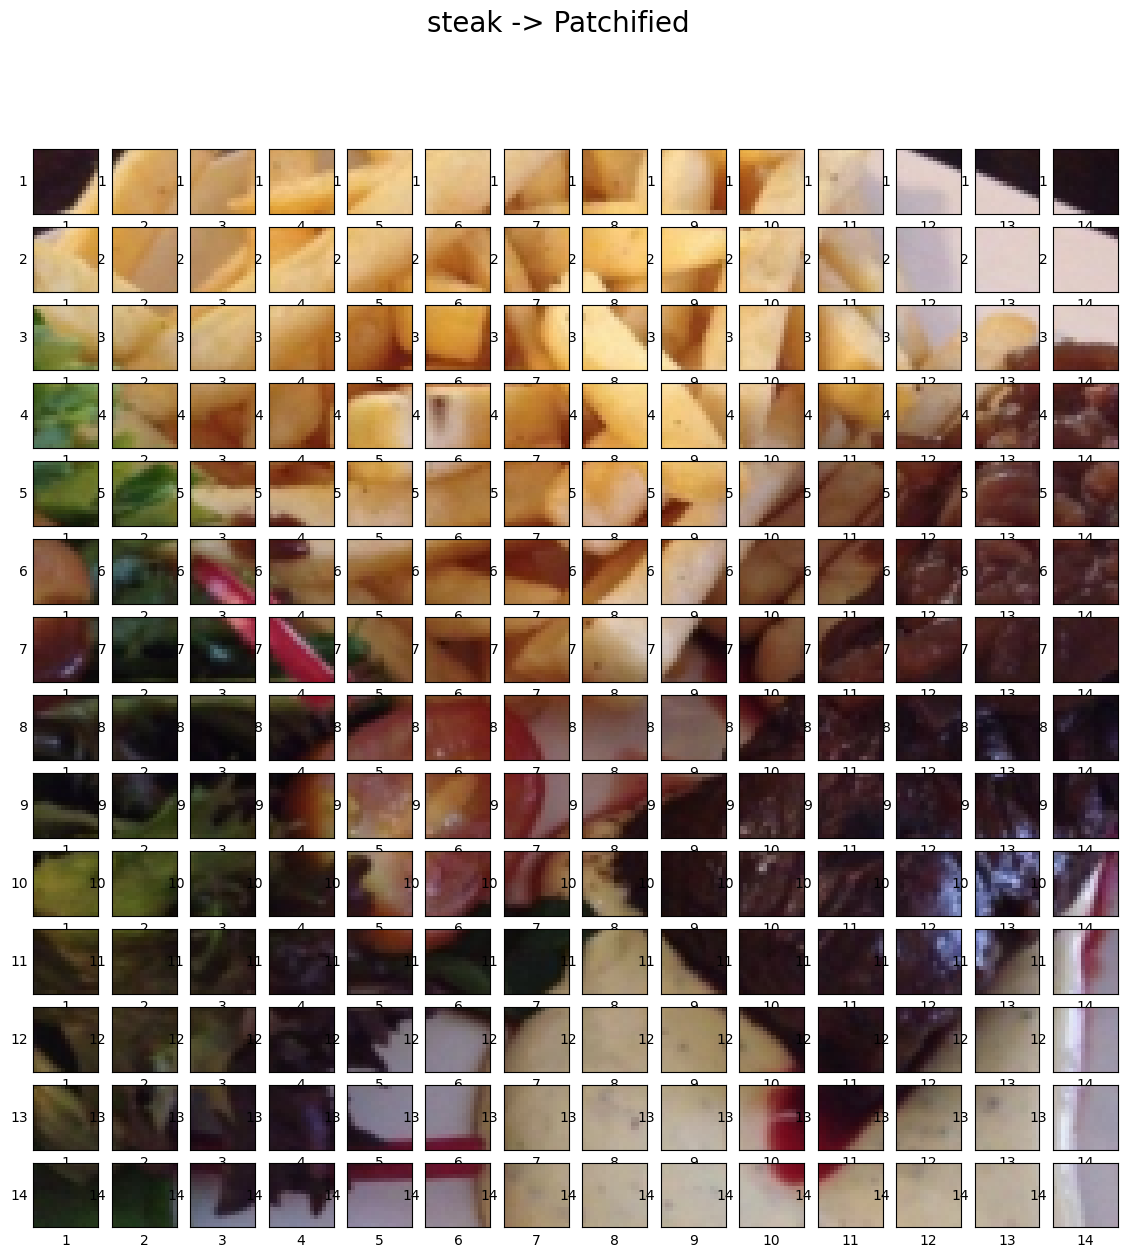

In [39]:
# Let's iterate through whole image
# Setup hyperparameters
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"{bcolors.OKGREEN}[INFO] Number of patches per row: {num_patches}\
      \npatch_size {patch_size} pixels x {patch_size} pixels each.\
      \nNumber of patches per column: {num_patches}\
        \nTotal number of patches: {num_patches**2}\
      {bcolors.ENDC}")

# Create a series of subplots
fig, ax = plt.subplots(
    nrows=int(num_patches),
    ncols=int(num_patches),
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# Loop througgh height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color_channels))
        ax[i, j].imshow(image_permuted[patch_height: patch_height+patch_size, #iterate through height
                                       patch_width: patch_width+patch_size, #iterate through width
                                       :])
        # Setup up label information, remove the ticks for better visualization 
        ax[i, j].set_ylabel(i+1,
                            rotation="horizontal",
                            horizontalalignment="right",
                            verticalalignment="center")
        ax[i, j].set_xlabel(j+1)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=20) 
plt.show()       

## 4.3 Creating image patches with `torch.nn.Conv2d()`
*By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch*

In [40]:
from torch import nn

# set patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3, # input image has 3 color channels
    out_channels=patch_size*patch_size*3, # each patch will be 16x16 pixels in size
    kernel_size=patch_size, # kernel size will be 16x16 pixels
    stride=patch_size, # stride will be 16 pixels
    padding=0
)

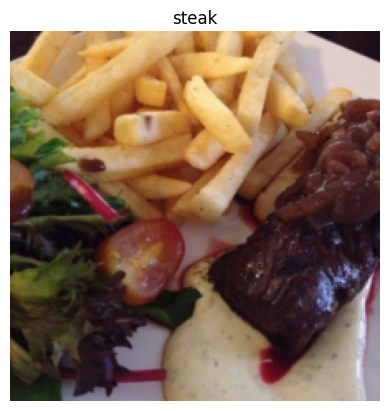

In [41]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust image for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [42]:
# Pass the imaeg through the conv2d layer
img_out_of_conv = conv2d(image.unsqueeze(0))
print(img_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Let's visualize five random feature maps and see what they look like.

 [INFO] Random indexes: [204, 543, 699, 442, 626]


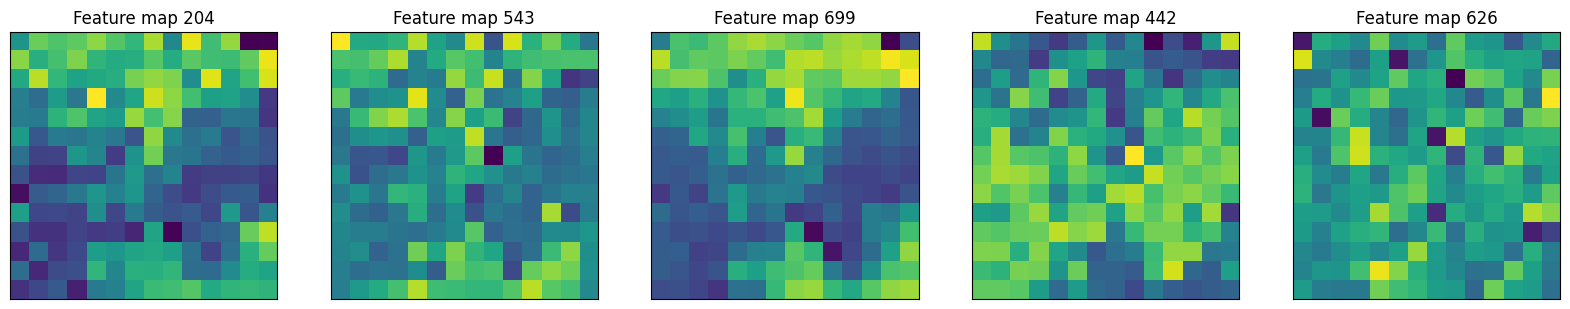

In [45]:
# Plot random 5 convolutional features maps
import random
random_indexes = random.sample(range(0,768), k=5)
print(f"{bcolors.OKCYAN} [INFO] Random indexes: {random_indexes}{bcolors.ENDC}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))

# Loop through random indexes and plot the feature maps
for i, index in enumerate(random_indexes):
    image_conv_feature_map = img_out_of_conv[:, index, :, :].squeeze()
    axs[i].imshow(image_conv_feature_map.detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], title=f"Feature map {index}")

In [47]:
# Get a single feature map in tensor form
single_feature_map = img_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.1501, -0.4733, -0.3374, -0.4259, -0.4213, -0.4050, -0.3914,
           -0.3886, -0.3811, -0.3182, -0.3901, -0.4132,  0.0237, -0.0714],
          [-0.4731, -0.3555, -0.4294, -0.3783, -0.3907, -0.3938, -0.4483,
           -0.5165, -0.4437, -0.3772, -0.3660, -0.3803, -0.4139, -0.5255],
          [-0.2487, -0.3245, -0.3487, -0.3447, -0.2196, -0.2471, -0.3360,
           -0.3933, -0.3979, -0.3240, -0.3664, -0.4480, -0.3426, -0.4310],
          [-0.1730, -0.2502, -0.2758, -0.2925, -0.4305, -0.3740, -0.2919,
           -0.3823, -0.2897, -0.2285, -0.2093, -0.1496, -0.0585, -0.1035],
          [-0.1177, -0.0769, -0.2243, -0.2428, -0.2248, -0.2744, -0.3645,
           -0.3645, -0.2198, -0.2736, -0.1961, -0.0989, -0.1542, -0.1299],
          [-0.1864, -0.0530, -0.2426, -0.1841, -0.2313, -0.1878, -0.1404,
           -0.2119, -0.3362, -0.1590, -0.1356, -0.1534, -0.1297, -0.1109],
          [-0.0327, -0.0263, -0.0430, -0.2069, -0.2357, -0.1310, -0.2342,
           -0.3580, -0.1280, -0.

In [48]:
asda

NameError: name 'asda' is not defined